# End-to-End Fuel Consumption Prediction Pipeline
### **Project Overview**
This project focuses on building a scalable Machine Learning pipeline using **Apache Spark (PySpark)** to predict vehicle fuel efficiency (MPG). The workflow simulates a production-grade environment involving:
1. **ETL Processes:** Ingesting and cleaning raw data.
2. **Feature Engineering:** Transforming categorical and numerical features using Vector Assemblers and Standard Scalers.
3. **Modeling:** Training a Linear Regression model on a distributed cluster.
4. **Evaluation:** Analyzing model performance using RMSE and R-Squared metrics.

**Tech Stack:** Python, PySpark MLlib, Data Engineering.
**Data Source:** [UCI Machine Learning Repository - Auto MPG Data Set](https://archive.ics.uci.edu/ml/datasets/auto+mpg)

----


## Setup


### Installing Required Libraries

In [1]:
!pip install pyspark==2.4.3 findspark
!pip install findspark -q

### Importing Required Libraries

In [2]:
# --- 1. Environment Setup ---
import logging
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize Spark Session with a professional app name
spark = SparkSession.builder \
    .appName("AutoMPG_Production_Pipeline") \
    .getOrCreate()

# Set log level to reduce noise
spark.sparkContext.setLogLevel("WARN")

print("Spark Session Initialized Successfully.")
print(f"Spark Version: {spark.version}")

26/02/16 22:19:06 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


Spark Session Initialized Successfully.
Spark Version: 2.4.3


### Load the csv file into a dataframe


Download the data file


In [3]:
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-BD0231EN-Coursera/datasets/mpg-raw.csv


--2026-02-16 22:19:12--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-BD0231EN-Coursera/datasets/mpg-raw.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104, 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14354 (14K) [text/csv]
Saving to: ‘mpg-raw.csv.4’

mpg-raw.csv.4       100%[===================>]  14.02K  --.-KB/s    in 0.001s  

2026-02-16 22:19:12 (10.6 MB/s) - ‘mpg-raw.csv.4’ saved [14354/14354]



Load the dataset into the spark dataframe


In [4]:
# --- 2. Data Ingestion & Preprocessing ---

# Load Data
raw_data_path = "mpg-raw.csv"  # Ensure this file exists
df = spark.read.csv(raw_data_path, header=True, inferSchema=True)

print(f"Raw Data Count: {df.count()}")

# Cleaning Pipeline:
# 1. Rename columns for consistency
# 2. Drop duplicates
# 3. Drop rows with null values to ensure model stability
df_clean = df.withColumnRenamed("Engine Disp", "Engine_Disp") \
             .dropDuplicates() \
             .dropna()

print(f"Cleaned Data Count: {df_clean.count()}")

# Show sample of the prepared data
df_clean.show(5)

Raw Data Count: 406


Cleaned Data Count: 385
+----+---------+-----------+----------+------+----------+----+--------+
| MPG|Cylinders|Engine_Disp|Horsepower|Weight|Accelerate|Year|  Origin|
+----+---------+-----------+----------+------+----------+----+--------+
|39.1|        4|       79.0|        58|  1755|      16.9|  81|Japanese|
|18.0|        6|      225.0|       105|  3121|      16.5|  73|American|
|18.0|        3|       70.0|        90|  2124|      13.5|  73|Japanese|
|31.5|        4|       98.0|        68|  2045|      18.5|  77|Japanese|
|18.0|        8|      307.0|       130|  3504|      12.0|  70|American|
+----+---------+-----------+----------+------+----------+----+--------+
only showing top 5 rows



## Machine Learning Pipeline creation


### Load data from "mpg-cleaned.parquet" into a dataframe


In [5]:
# --- 3. Constructing the ML Pipeline ---

# Stage 1: Handle Categorical Data (Origin -> Numerical Index)
indexer = StringIndexer(inputCol="Origin", outputCol="OriginIndex")

# Stage 2: Assemble Features into a single vector
# We select features that likely impact fuel consumption
feature_cols = ['Cylinders', 'Engine_Disp', 'Horsepower', 'Weight', 'Accelerate', 'Year']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="raw_features")

# Stage 3: Feature Scaling
# Crucial because 'Weight' (thousands) and 'Cylinders' (single digits) have different scales
scaler = StandardScaler(inputCol="raw_features", outputCol="scaled_features")

# Stage 4: Define the Model (Linear Regression)
lr = LinearRegression(featuresCol="scaled_features", labelCol="MPG")

# Combine into a single Pipeline workflow
pipeline = Pipeline(stages=[indexer, assembler, scaler, lr])

print("Pipeline constructed successfully.")

Pipeline constructed successfully.


## Model Evaluation


### Predict using the model on testing data


In [6]:
# --- 4. Model Training & Evaluation ---

# Split data: 70% Training (Learning), 30% Testing (Validation)
train_data, test_data = df_clean.randomSplit([0.7, 0.3], seed=42)

print("Training model on distributed cluster...")
model = pipeline.fit(train_data)

print("Generating predictions...")
predictions = model.transform(test_data)

# Evaluate the model
evaluator_rmse = RegressionEvaluator(labelCol="MPG", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="MPG", predictionCol="prediction", metricName="r2")

rmse = evaluator_rmse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print("-" * 30)
print(f"Model Performance Metrics:")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-Squared (Accuracy): {r2:.2f}")
print("-" * 30)

# Show actual vs predicted values
predictions.select("MPG", "prediction", "Weight", "Year").show(5)

Training model on distributed cluster...


26/02/16 22:19:58 WARN util.Instrumentation: [481916db] regParam is zero, which might cause numerical instability and overfitting.
[Stage 20:========>                                              (31 + 8) / 200]26/02/16 22:20:00 WARN netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
26/02/16 22:20:00 WARN netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
26/02/16 22:20:04 WARN netlib.LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
26/02/16 22:20:04 WARN netlib.LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


Generating predictions...


------------------------------
Model Performance Metrics:
Root Mean Squared Error (RMSE): 3.39
R-Squared (Accuracy): 0.79
------------------------------
+----+------------------+------+----+
| MPG|        prediction|Weight|Year|
+----+------------------+------+----+
|18.0| 20.33892678637937|  3121|  73|
|39.1|34.882930399068485|  1755|  81|
|26.8|27.137126609786346|  2700|  79|
|15.0|18.367297474395752|  3730|  75|
|18.0| 17.63415268778095|  3785|  75|
+----+------------------+------+----+
only showing top 5 rows



## Visualization & Analysis



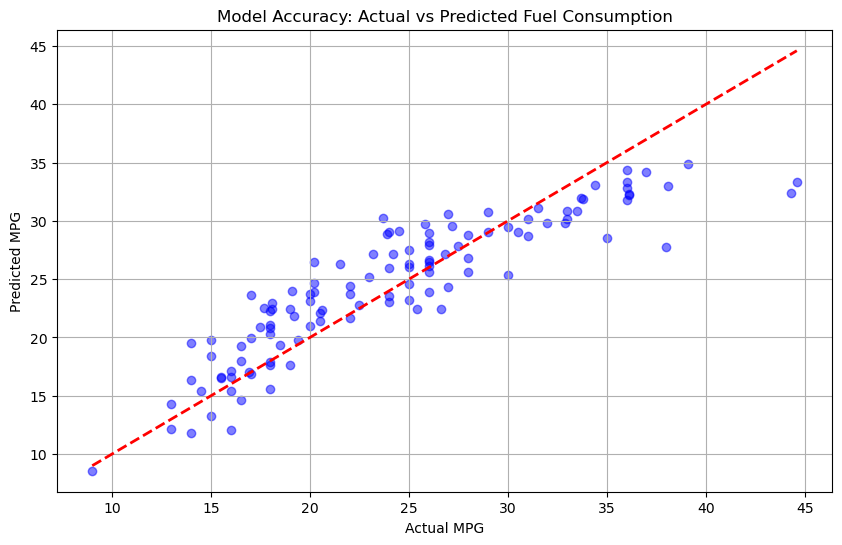

In [7]:
# --- 5. Visualization (Actual vs Predicted) ---
import matplotlib.pyplot as plt
import pandas as pd

# Convert predictions to Pandas for plotting (only for the test set)
# Note: In huge datasets, we would only sample, but here data is small enough.
preds_pd = predictions.select("MPG", "prediction").toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(preds_pd["MPG"], preds_pd["prediction"], alpha=0.5, color='blue')
plt.plot([preds_pd["MPG"].min(), preds_pd["MPG"].max()], 
         [preds_pd["MPG"].min(), preds_pd["MPG"].max()], 'r--', lw=2)
plt.xlabel("Actual MPG")
plt.ylabel("Predicted MPG")
plt.title("Model Accuracy: Actual vs Predicted Fuel Consumption")
plt.grid(True)
plt.show()

## Model persistance

### Save the model

In [8]:
# Save the model for production

model_path = "fuel_consumption_model"
model.write().overwrite().save(model_path)
print(f"Model saved successfully at: {model_path}")


Model saved successfully at: fuel_consumption_model


In [9]:
spark.stop()

<!--
|Date (YYYY-MM-DD)|Version|Changed By|Change Description|
|-|-|-|-|
|2023-05-26|0.1|Ramesh Sannareddy|Initial Version Created|
-->
